In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
users_max_id = 6040
movie_max_id = 3952
correlations_data = np.fromfile('./correlations_data_set_saved', dtype=float)
correlations_data=correlations_data.reshape(movie_max_id+1,movie_max_id+1)

bad_movies = np.load('./subsets/bad_movies.npy')
bad_movies = bad_movies.reshape((-1)).tolist()

Data=np.load('./movies_data_with_categories_saved.npy')
X=Data.reshape(3953, 22)
permutation= np.load('./subsets/subset105.npy').reshape((-1)).astype(int)

bad_indices = np.zeros((permutation.shape[0]), dtype=bool)
for movie in bad_movies: 
    bad_indices = np.logical_or(permutation==movie,bad_indices)
permutation=permutation[~(bad_indices.reshape(-1))]


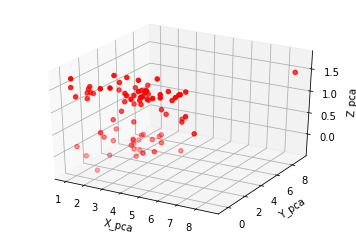

In [17]:
X=X[permutation,:]
cov = (1/X.shape[0])*np.matmul(np.transpose(X[1:,1:]),X[1:,1:])
U,_,_ = np.linalg.svd(cov)
U_reduce=U[:,:3]
Z = np.matmul(X[1:,1:],U_reduce)
X[1:,1:4]=Z
X=X[:,:4]
X=X+np.array([0,-6,2,1])
centroids_number = 300
feature_number = 3
radius = 0.3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X_pca')
ax.set_ylabel('Y_pca')
ax.set_zlabel('Z_pca')
ax.scatter(X[1:,1], X[1:,2], X[1:,3], c='r', marker='o')
plt.show()

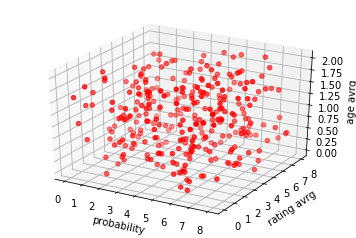

In [18]:
centroids = np.random.rand(centroids_number,feature_number)*np.array([8,8,2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('probability')
ax.set_ylabel('rating avrg')
ax.set_zlabel('age avrg')
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='r', marker='o')
plt.show()

In [19]:
centroids_assignment = np.zeros(shape=(X.shape[0],centroids_number))
final_centroids = np.zeros(shape=(X.shape[0],1))
#algorithem:: shift means
#(1)-remove irrelevent centroids
for i in range(1,X.shape[0]):
    centroids_assignment[i,:] = (np.linalg.norm(X[i,1:]-centroids,axis=1) < radius)

indicies = ~(centroids_assignment==0).all(0) #find zero columns
centroids_assignment=centroids_assignment[:,indicies] #clear zero columns
centroids=centroids[indicies,:] #clear corresponding centroids
#(2)-find the centroids
for j in range(0,1) :
    for i in range(1,X.shape[0]):
        centroids_assignment[i,:] = (np.linalg.norm(X[i,1:]-centroids,axis=1) < radius)
        
    for i in range(0,centroids.shape[0]):
        X_near_centroid=X[centroids_assignment[:,i]==1,1:]
        centroids[i,:] =  np.mean(X_near_centroid,axis=0).T
    
#(3)-remove dups      
centroids=np.unique(centroids,axis=0) #remove exact dups
count = centroids.shape[0]
new_centroids = np.zeros((1,feature_number)) #calculate near centroids
while count>=1:
    indicies= np.linalg.norm(centroids[0,:]-centroids,axis=1) < 0.9*radius #find close centroids
    new_centroid = np.mean(centroids[indicies,:],axis=0) #calulate new centroids
    centroids = centroids[~indicies,:] # remove used centroids
    count =centroids.shape[0]
    new_centroids = np.row_stack((new_centroid,new_centroids))#add new centroid to the list
centroids = new_centroids[:-1,:]


#(4)-choose a centroid for each point
for i in range(1,X.shape[0]):
    final_centroids[i,:]=np.argmin(np.linalg.norm(centroids-X[i,1:], axis=1))

print("finished...")

finished...


In [20]:
data_clusters =np.unique(final_centroids[1:])
data_clusters=data_clusters+1
final_centroids[1:]=final_centroids[1:]+1
sizes=[]
for x in data_clusters:
    cluster_size = np.sum((final_centroids==x).astype(int))
    sizes.append((cluster_size))
print(sizes)
print(np.sum(np.array(sizes)))

[16, 7, 6, 15, 5, 3, 2, 3, 6, 20, 1]
84


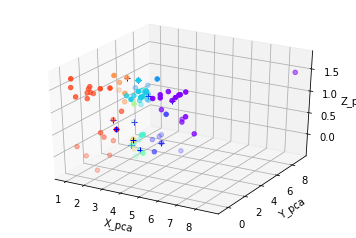

In [21]:
X_colors= np.unique(final_centroids[1:])
colors = plt.cm.rainbow(np.linspace(0, 1, len(X_colors)))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X_pca')
ax.set_ylabel('Y_pca')
ax.set_zlabel('Z_pc')
for x,c in zip(X_colors,colors):
    X_c = X[(final_centroids==x)[:,0],:]
    ax.scatter(X_c[:,1],X_c[:,2],X_c[:,3], c=c, marker='o')       

ax.plot(centroids[:,0],centroids[:,1],centroids[:,2],'b+')
plt.show()

In [22]:
clustering_vector = np.zeros((movie_max_id+1))
for i in range(1,X.shape[0]):
    clustering_vector[X[i,0].astype(int)]=final_centroids[i,:]

Indecies = np.array([x for x in range(0,movie_max_id+1)])   
cost=0
for c in data_clusters:
    cluster = (clustering_vector == c)
    if np.sum(cluster.astype(int))==1:
        cost=cost + np.log(1/(correlations_data[Indecies[cluster][0],Indecies[cluster][0]]))
    else:
        c_i=0
        for t in Indecies[cluster]:
            for j in Indecies[cluster]:
                if t!=j:
                    if correlations_data[t,j]==0:
                            correlations_data[t,j]=correlations_data[j,t]
                    c_i=c_i+np.log(1/correlations_data[t,j])
        cost=cost+(c_i/2)*(1/(np.sum(cluster)-1))
print(cost)  

749.3508418751715
